# Własne środowisko PettingZoo
### Wykonali Bartłomiej Tarcholik

Ideą projektu jest stworzenie środowiska, które będzie uczyło 2 typy agentów - ryby oraz rekiny. Agenci mają za zadanie zapewnić sobie przeżycie w obliczu głodu.

Ten raport pozwala załadować wytrenowany model i plik z danymi treningu.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
from env.aquarium import Aquarium
import os
import json

In [2]:
env = Aquarium(render_mode="human")
# model_dir = os.getcwd() + '/'
model_dir = "C:/ml/models/aquarium/conv14/"

Wczytywany jest model. Modele trenowane są w pliku Aquarium-train.py, który zawiera implementację DQN pochodzącą z książki "Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems, 2nd Edition".

In [3]:
fish_model = tf.keras.models.load_model(model_dir + 'fish.h5')
shark_model = tf.keras.models.load_model(model_dir + 'shark.h5')
models = {}
models["fish"] = fish_model
models["shark"] = shark_model

In [4]:
def action_predict(state, model):
  aqu = np.array(state["observation"]["surrounding"]["aquarium"])
  aqu = np.reshape(aqu, (1, env.angle_precision))
  walls = np.array(state["observation"]["surrounding"]["walls"])
  walls = np.reshape(walls, (1, env.angle_precision))
  food = np.array(state["observation"]["surrounding"]["food"])
  food = np.reshape(food, (1, env.angle_precision))
  fishes = np.array(state["observation"]["surrounding"]["fishes"])
  fishes = np.reshape(fishes, (1, env.angle_precision))
  sharks = np.array(state["observation"]["surrounding"]["sharks"])
  sharks = np.reshape(sharks, (1, env.angle_precision))
  data = np.array(state["observation"]["data"])
  data = np.reshape(data, (1, env.angle_precision))
  Q_values = model.predict(
      [[aqu], [walls], [food], [fishes], [sharks], [data]], verbose=0)
  # print(Q_values)
  # print(np.argmax(Q_values[0]))
  return np.argmax(Q_values[0])

Za każdym razem resetowane jest środowisko i odgrywany "scenariusz" od początku.

In [9]:
howManyEpisodes = 30
for episode in range(howManyEpisodes):
  env.reset()
  truncated = []
  for agent in env.agent_iter(env.max_timesteps):
    if agent not in truncated:
      observation, reward, termination, truncation, info = env.last()
    if termination or truncation:
      truncated.append(agent)
    agentType = "fish"
    if "shark" in agent:
      agentType = "shark"
    if agent in truncated:
      action = None
      env.step(action)
    else:
      action = action_predict(observation, models[agentType])
      # action = env.action_space(agent).sample()
      env.step(action)

env.close()

In [6]:
with open(model_dir + 'agent_rewards.json') as json_file:
    agent_rewards = json.load(json_file)

fish_score = []
shark_score = []

for agent in agent_rewards:
    for episode in agent_rewards[agent]:
        if "fish" in agent:
            if len(fish_score) <= int(episode):
                fish_score.append(np.mean(agent_rewards[agent][episode]))
            else:
                fish_score[int(episode)] += np.mean(agent_rewards[agent][episode])
        else:
            if len(shark_score) <= int(episode):
                shark_score.append(np.mean(agent_rewards[agent][episode]))
            else:
                shark_score[int(episode)] += np.mean(agent_rewards[agent][episode])

Poprzez kilkanaście różnych prób niestety nie udało nam się osiągnąć realnie wytrenowanych agentów. Szkolenie zawsze w pewnym momencie się zatrzymywało i nie wznawiało.

Aktualne rezultaty są oparte o modele z filtrem konwolucyjnym 1D oraz discount factor równym 0.8.

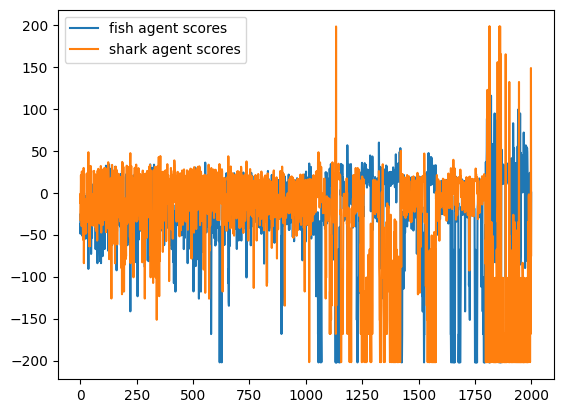

In [7]:
plt.plot(fish_score, label="fish agent scores")
plt.plot(shark_score, label="shark agent scores")
plt.legend()
plt.show()

In [10]:
def getScores(root_dir):
  with open(root_dir + 'agent_rewards.json') as json_file:
      agent_rewards = json.load(json_file)

  fs = []
  ss = []

  for agent in agent_rewards:
      for episode in agent_rewards[agent]:
          if "fish" in agent:
              if len(fs) <= int(episode):
                  fs.append(np.mean(agent_rewards[agent][episode]))
              else:
                  fs[int(episode)] += np.mean(agent_rewards[agent][episode])
          else:
              if len(ss) <= int(episode):
                  ss.append(np.mean(agent_rewards[agent][episode]))
              else:
                  ss[int(episode)] += np.mean(agent_rewards[agent][episode])
  return fs, ss

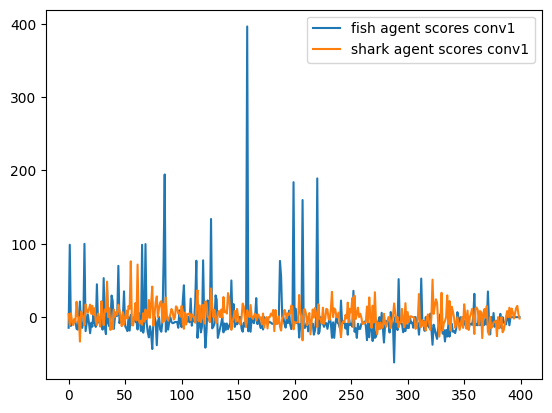

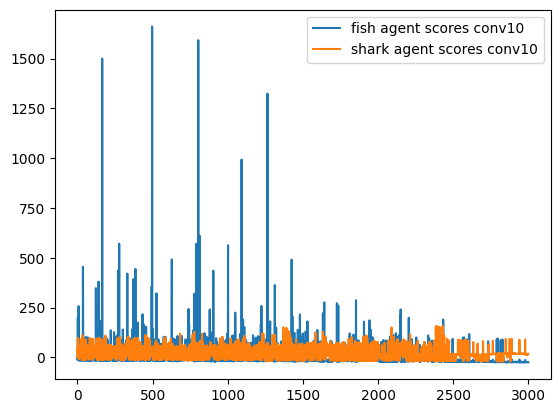

c:\Users\creep\Documents\GitHub\inteligencja_obliczeniowa\Zadanie 3 - Gymnasium\venv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\creep\Documents\GitHub\inteligencja_obliczeniowa\Zadanie 3 - Gymnasium\venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


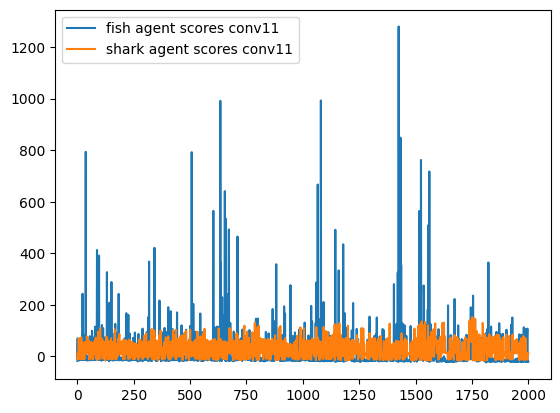

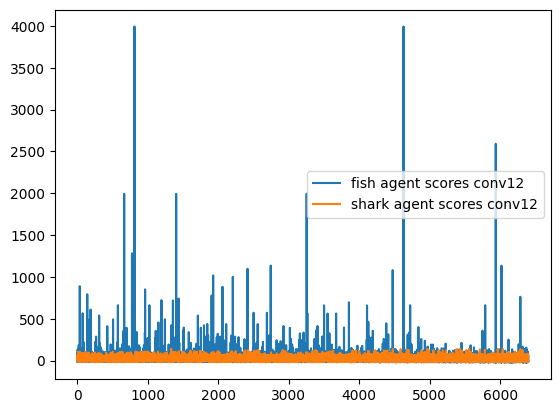

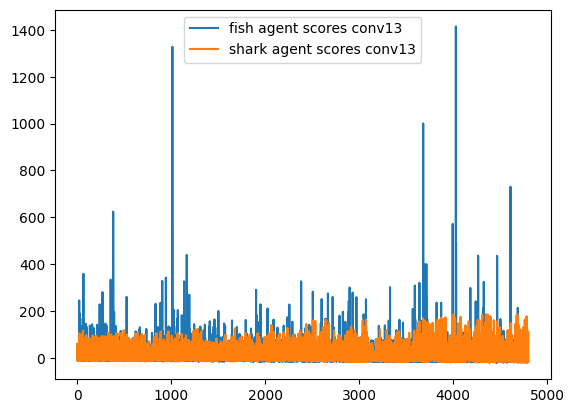

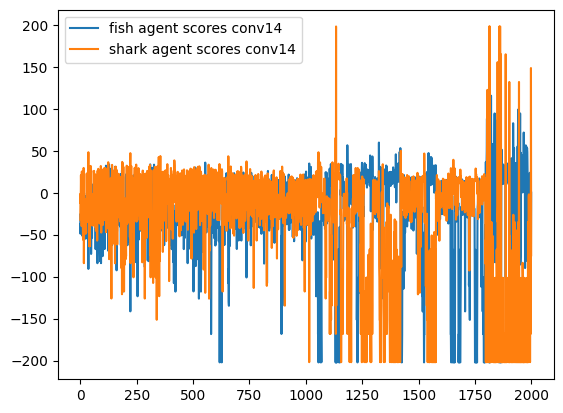

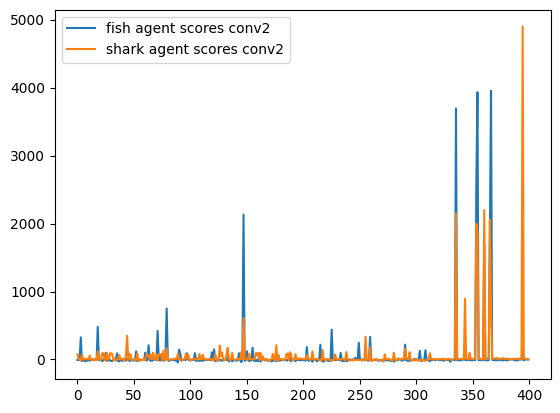

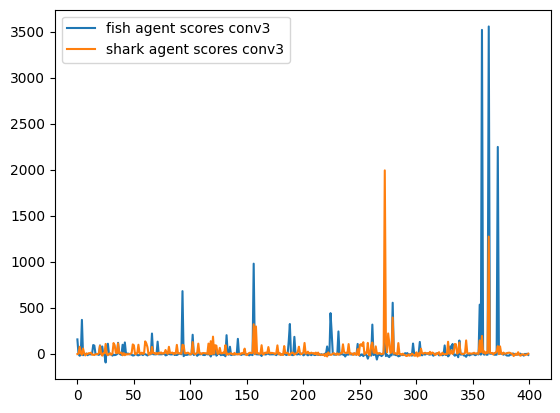

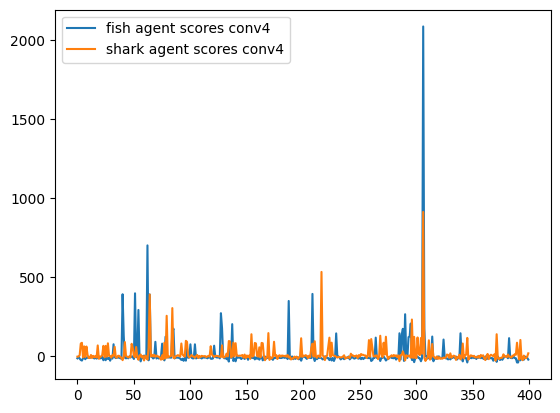

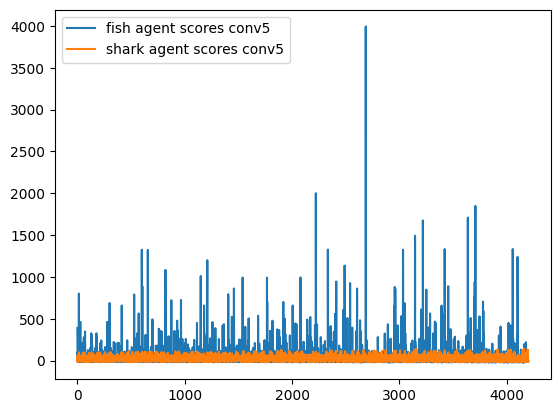

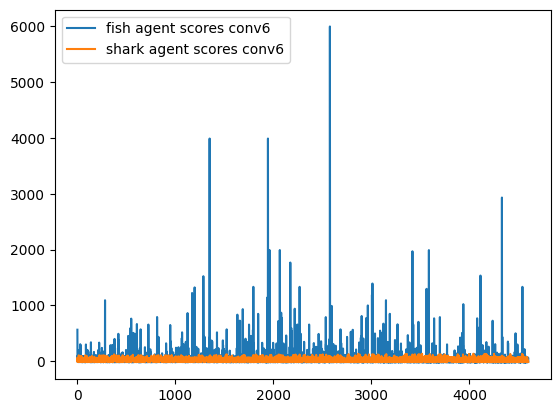

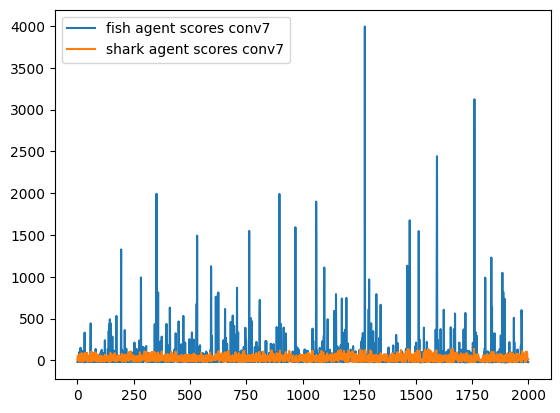

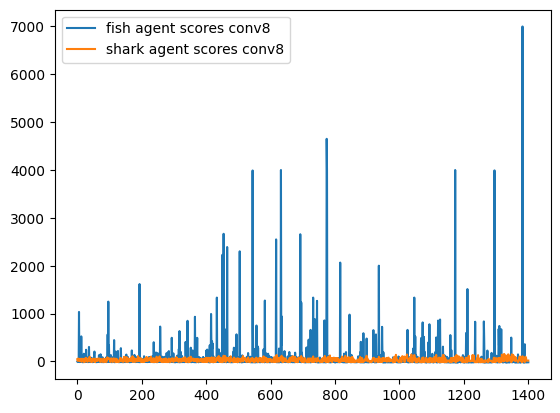

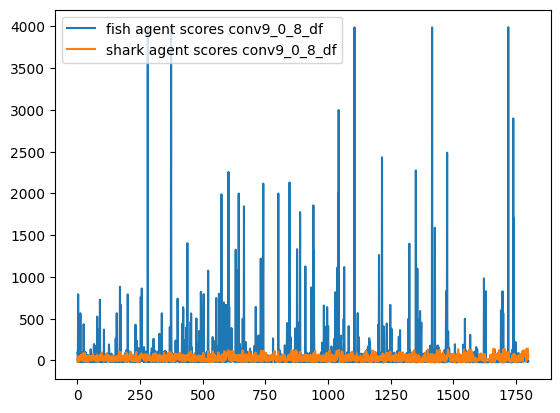

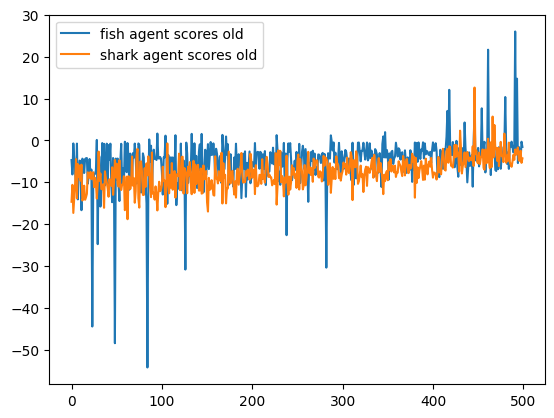

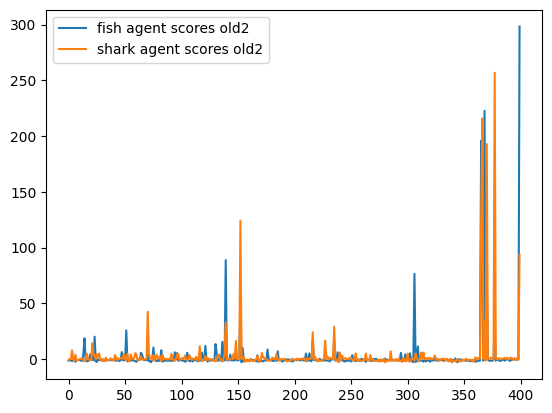

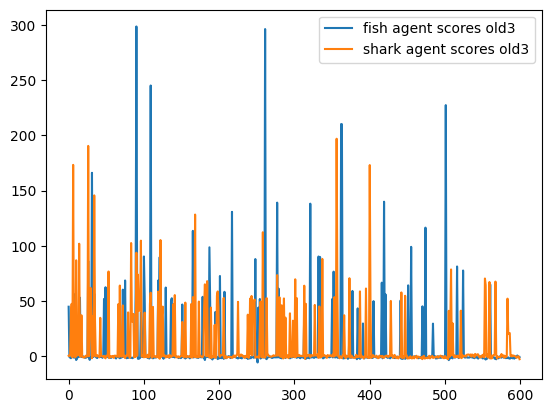

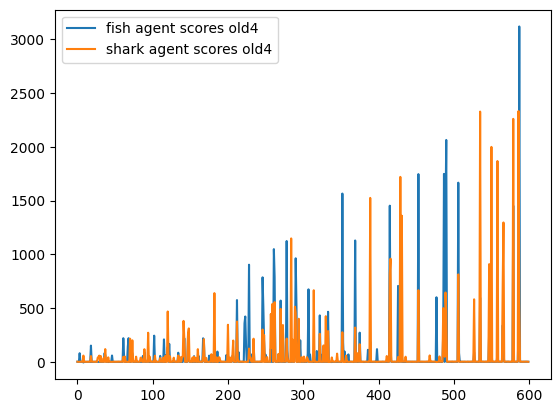

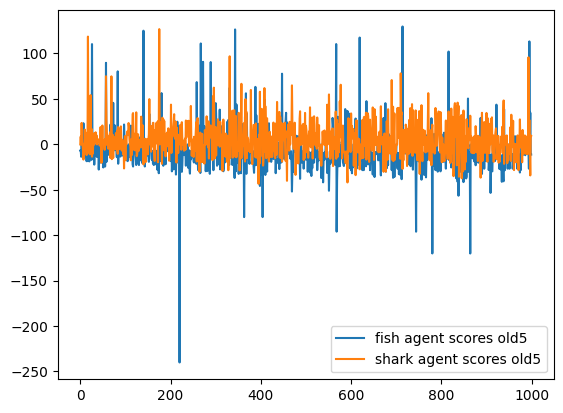

In [13]:
rootdir = 'C:/ml/models/aquarium/'

for sdir in os.listdir(rootdir):
    fish_s, shark_s = getScores(rootdir + sdir + '/')
    plt.plot(fish_s, label="fish agent scores " + sdir)
    plt.plot(shark_s, label="shark agent scores " + sdir)
    plt.legend()
    plt.show()